## Part1 Three layer network (60 points):

Create a notebook called threelayer.ipynb.
Extend the fully-connected two layer perceptron shown in class for the regression
problem by one more layer to have two hidden layers.
For this, take a long look at the derivation of the backpropagation. As you can see,
the derivation of the internal derivatives is always the same, no matter the number
of hidden layers.
Armed with this knowledge, it should be easy to extend the different functions in
the notebook.
The create_model function should now of course receive a list of values for the
number of hidden_nodes in each layer - in addition, please extend the functionality,
so that I can pass the activation function type as a string already here:
```python
def create_model(X, hidden_nodes, output_dim = 2, activation_function = 'relu') :
    return
```
forward, calculate_loss, backprop should of course be extended
accordingly to deal with the added number of layers and the activation function
choice.
Next, do a series of tests for the x^2+y^2+1 function using a learning rate of 0.001, a
tolerance threshold of 0.0001, maximum iterations of 100,000, NO sgd, and NO
regularization, and a “relu” function, comparing the “old” two-layer version with
your “new” three-layer version as follows:
- take 8 neurons for the two-layer version and 4 + 4 neurons for the three-layer
version, and run each network 20 times, recording the loss and the number
of iterations it needs
- repeat this with 16 neurons for the two-layer version and 8+8 neurons for the
three-layer version and 20 runs each
- which network architecture converges “better” (earlier? lower error?). Plot
the results nicely in one graph for errors and in another for number of
iterations and comment on the results.

In [1]:
# numpy, matplotlib imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# activation functions
def relu(X):
    return np.maximum(X, 0)

def relu_derivative(X):
    return 1. * (X > 0)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return 1.-tanh(X)**2

def logistic(X):
    return 1./(1. + np.exp(-X))

def logistic_derivative(X):
    return logistic(X)*(1. - logistic(X))

# Activation functions mapping
activation_functions = {
    'relu': relu,
    'tanh': tanh,
    'logistic': logistic
}

# Activation functions derivatives mapping
activation_derivatives = {
    'relu': relu_derivative,
    'tanh': tanh_derivative,
    'logistic': logistic_derivative
}

In [3]:
# create a two-layer neural network
def old_create_model(X, hidden_nodes, output_dim = 2):
    # this will hold a dictionary of layers
    model = {}
    
    # input dimensionality
    input_dim = X.shape[1]
    
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim)
    
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))

    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
    
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    
    return model

# defines the forward pass given a model and data
def old_feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # first layer
    z1 = x.dot(W1) + b1

    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = relu(z1)

    # second layer
    z2 = a1.dot(W2) + b2

    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def old_calculate_loss(model,X,y):
    num_examples = X.shape[0]
    
    # what are the current predictions
    z1, a1, z2, out = old_feed_forward(model, X)

    # calculate L2 loss
    loss = 0.5 * np.sum((out - y) ** 2)

    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def old_backprop(X,y,model,z1,a1,z2,output):
    num_examples = X.shape[0]
    
    # derivative of loss function
    delta3 = (output-y)/num_examples
    
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    
    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)

    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T) * logistic_derivative(a1) #if logistic
    #delta2 = delta3.dot(model['W2'].T) * tanh_derivative(a1) #if tanh
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1) #if ReLU

    # multiply by input data
    dW1 = np.dot(X.T, delta2)
    
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)

    return dW1, dW2, db1, db2

# simple training loop
def old_train(model, X, y, num_passes=100000, learning_rate = 0.001, tolerance=0.0001):
    # variable that checks whether we break iteration
    done = False

    # keeping track of losses
    previous_loss = float('inf')
    
    losses = []

    # iteration counter
    i = 0
    
    while not done:
        # get predictions
        z1,a1,z2,output = old_feed_forward(model, X)
        
        # feed this into backprop
        dW1, dW2, db1, db2 = old_backprop(X, y, model, z1, a1, z2, output)

        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2

        loss = old_calculate_loss(model, X, y)
        if i % 1000 == 0:
            losses.append(loss)
            print("two-layer Loss after iteration {}: {}".format(i, loss))
        if np.abs((previous_loss - loss) / previous_loss) < tolerance:
            done = True
        previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True
            
    return model, losses, i

In [4]:
# create a three-layer neural network
def create_model(X, hidden_nodes, output_dim = 2, activation_function='relu'):
    # this will hold a dictionary of layers
    model = {}
    
    #save activation function to model
    model['activation_function'] = activation_function
    
    # input dimensionality
    input_dim = X.shape[1]
    
    # [i -> 1]weights and biases from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes[0]) / np.sqrt(input_dim)
    model['b1'] = np.zeros((1, hidden_nodes[0]))
    
    # [1 -> 2]weights and biases  from  hidden layer 1 to hidden layer 2
    model['W2'] = np.random.randn(hidden_nodes[0], hidden_nodes[1]) / np.sqrt(hidden_nodes[0])
    model['b2'] = np.zeros((1, hidden_nodes[1]))

    # [2 -> o]weights and biases from hidden layer 2 to output
    model['W3'] = np.random.randn(hidden_nodes[1], output_dim) / np.sqrt(hidden_nodes[1])
    model['b3'] = np.zeros((1, output_dim))
    
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # get activation function
    act_func = activation_functions.get(model['activation_function'])
    
    # first layer
    z1 = x.dot(W1) + b1
    a1 = act_func(z1)

    # second layer
    z2 = a1.dot(W2) + b2
    a2 = act_func(z2)
    
    # third layer
    z3 = a2.dot(W3) + b3
    out = z3
    
    return z1, a1, z2, a2, z3, out
    
# define the regression loss
def calculate_loss(model,X,y):
    num_examples = X.shape[0]
    # what are the current predictions
    z1, a1, z2, a2, z3, out = feed_forward(model, X)

    # calculate L2 loss
    loss = 0.5 * np.sum((out - y) ** 2)

    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,a2,z3,output):
    num_examples = X.shape[0]
    
    # get activation function derivate
    act_func_derivative = activation_derivatives.get(model['activation_function'])

    # Derivative of loss function for output layer
    delta4 = (output - y) / num_examples

    # multiply this by activation outputs of hidden layer
    dW3 = a2.T.dot(delta4)

    # and over all neurons
    db3 = np.sum(delta4, axis=0, keepdims=True)

    # derivative of activation function
    delta3 = delta4.dot(model['W3'].T) * act_func_derivative(a2)

    # multiply this by hidden layer outputs
    dW2 = a1.T.dot(delta3)

    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)

    # derivative of activation function
    delta2 = delta3.dot(model['W2'].T) * act_func_derivative(a1)

    # multiply by input data
    dW1 = X.T.dot(delta2)

    # and over all neurons
    db1 = np.sum(delta2, axis=0)

    return dW1, dW2, dW3, db1, db2, db3

# simple training loop
def train(model, X, y, num_passes=100000, learning_rate = 0.001, tolerance = 0.0001):
    # variable that checks whether we break iteration
    done = False

    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while not done:
        # get predictions
        z1, a1, z2, a2, z3, output = feed_forward(model, X)

        # feed this into backprop
        dW1, dW2, dW3, db1, db2, db3 = backprop(X, y, model, z1, a1, z2, a2, z3, output)
        
        # Update weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        model['W3'] -= learning_rate * dW3
        model['b3'] -= learning_rate * db3

        # calculate loss
        loss = calculate_loss(model, X, y)

        # print loss per 1000 iterations
        if i % 1000 == 0:
            losses.append(loss)
            print("three-layer Loss after iteration {}: {}".format(i, loss))

        # Check for convergence
        if np.abs((previous_loss - loss) / previous_loss) < tolerance:
            done = True
        previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True
    return model, losses, i

In [5]:
import time

# Generate the dataset based on the function f(x, y) = x^2 + y^2 + 1
# Randomly generate data points for x and y in the range [-1, 1]
np.random.seed(42)  # for reproducibility
num_samples = 1000
X = np.random.uniform(-8, 8, (num_samples, 2))
y = (X[:, 0] ** 2 + X[:, 1] ** 2 + 1).reshape(-1, 1)
print(X, y)

# Parameters
num_runs = 20
learning_rate = 0.001
tolerance = 0.0001
max_iterations = 100000

# Data structures to store results
results_old = {"8": {"losses": [], "iterations": []}}
results_new = {"4+4": {"losses": [], "iterations": []}}

# keeping time
start_time = time.time()

# Test the old (2-layer) network with 8 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 8, 1)
    _, losses, iterations = old_train(model_old, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_old["8"]["losses"].append(losses[-1])
    results_old["8"]["iterations"].append(iterations)

# Test the new (3-layer) network with 4+4 neurons
for _ in range(num_runs):
    model_new = create_model(X, [4,4], 1)
    _, losses, iterations = train(model_new, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_new["4+4"]["losses"].append(losses[-1])
    results_new["4+4"]["iterations"].append(iterations)

print(results_old, results_new)

# Update data structures to store results for the next configurations
results_old["16"] = {"losses": [], "iterations": []}
results_new["8+8"] = {"losses": [], "iterations": []}

# Test the old (2-layer) network with 16 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 16, 1)
    _, losses, iterations = old_train(model_old, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_old["16"]["losses"].append(losses[-1])
    results_old["16"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

# Test the new (3-layer) network with 8+8 neurons
for _ in range(num_runs):
    model_new = create_model(X, [8, 8], 1)
    _, losses, iterations = train(model_new, X, y, num_passes=max_iterations, learning_rate=learning_rate, tolerance=tolerance)
    results_new["8+8"]["losses"].append(losses[-1])
    results_new["8+8"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

print(results_old, results_new)

'''
# Update data structures to store results for the next configurations
results_old["32"] = {"losses": [], "iterations": []}
results_new["16+16"] = {"losses": [], "iterations": []}

# Test the old (2-layer) network with 32 neurons
for _ in range(num_runs):
    model_old = old_create_model(X, 32, 1)
    _, losses, iterations = old_train(model_old, X, y, 
                                      num_passes=max_iterations, 
                                      learning_rate=learning_rate, 
                                      tolerance=tolerance)
    results_old["32"]["losses"].append(losses[-1])
    results_old["32"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

# Test the new (3-layer) network with 16+16 neurons
for _ in range(num_runs):
    model_new = create_model(X, [16, 16], 1)
    _, losses, iterations = train(model_new, X, y, 
                                  num_passes=max_iterations, 
                                  learning_rate=learning_rate, 
                                  tolerance=tolerance)
    results_new["16+16"]["losses"].append(losses[-1])
    results_new["16+16"]["iterations"].append(iterations)
    # print("Done with run {}".format(_))

print(results_old, results_new)
'''

print("--- %s seconds ---" % (time.time() - start_time))

[[-2.0073581   7.2114289 ]
 [ 3.71190307  1.57853575]
 [-5.50370175 -5.50408767]
 ...
 [ 4.02200138  2.5112825 ]
 [ 7.30583394 -6.89667174]
 [-7.08712446 -3.4850068 ]] [[ 57.03419335]
 [ 17.2699995 ]
 [ 61.58571412]
 [ 85.32001627]
 [ 14.70072147]
 [116.36755104]
 [ 50.47632555]
 [ 52.5758223 ]
 [ 10.96709897]
 [ 13.34348861]
 [ 37.47379112]
 [ 16.63212904]
 [ 22.31332486]
 [ 24.14200483]
 [ 55.84740625]
 [ 31.75078355]
 [101.01365563]
 [ 80.85206132]
 [ 52.2111378 ]
 [ 10.60602421]
 [ 37.57685968]
 [ 99.39033365]
 [ 22.65775109]
 [ 10.17899375]
 [ 26.98363249]
 [ 76.82919504]
 [ 90.35627681]
 [ 49.01594266]
 [ 68.01179925]
 [ 61.7558943 ]
 [ 17.55654684]
 [ 33.91851759]
 [ 13.75203701]
 [ 57.38615741]
 [108.02490722]
 [ 43.21170047]
 [ 89.07021811]
 [ 25.37996639]
 [ 66.28654329]
 [ 43.90266353]
 [ 38.64391065]
 [ 57.08365865]
 [ 17.96986972]
 [ 19.34011009]
 [ 39.58066391]
 [ 49.68656051]
 [ 19.37151655]
 [ 19.80619705]
 [  2.4763739 ]
 [ 98.0178914 ]
 [ 61.97060053]
 [  9.84151258]


C:\Users\jws\AppData\Local\Temp\ipykernel_35640\41365746.py:112: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < tolerance:


two-layer Loss after iteration 2000: 8.8475399422964
two-layer Loss after iteration 3000: 6.717682967680359
two-layer Loss after iteration 0: 1263.4814371327614
two-layer Loss after iteration 1000: 20.560788533342777
two-layer Loss after iteration 2000: 9.33151562433909
two-layer Loss after iteration 3000: 6.805840488122652
two-layer Loss after iteration 0: 1334.413215990809
two-layer Loss after iteration 1000: 20.538915918032448
two-layer Loss after iteration 2000: 8.979107458271443
two-layer Loss after iteration 3000: 6.234711435606511
two-layer Loss after iteration 4000: 5.240775832494115
two-layer Loss after iteration 0: 1227.2707100262523
two-layer Loss after iteration 1000: 20.992417409761334
two-layer Loss after iteration 2000: 9.119168869614052
two-layer Loss after iteration 3000: 6.562950401320199
two-layer Loss after iteration 4000: 4.819073592702401
two-layer Loss after iteration 5000: 4.2306578542007935
two-layer Loss after iteration 0: 1267.3731236053886
two-layer Loss aft

C:\Users\jws\AppData\Local\Temp\ipykernel_35640\2251317011.py:131: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < tolerance:


three-layer Loss after iteration 1000: 17.23523398763797
three-layer Loss after iteration 0: 1459.0708119913807
three-layer Loss after iteration 1000: 17.753719313131775
three-layer Loss after iteration 0: 1413.6442349131614
three-layer Loss after iteration 1000: 11.112263626387747
three-layer Loss after iteration 0: 1309.8941923315815
three-layer Loss after iteration 1000: 18.086897610800694
three-layer Loss after iteration 0: 1319.4665920303419
three-layer Loss after iteration 0: 1300.5810240239553
three-layer Loss after iteration 1000: 15.969369226215779
three-layer Loss after iteration 0: 1259.5357851137194
three-layer Loss after iteration 0: 1443.6664081885497
three-layer Loss after iteration 1000: 68.88445279002465
three-layer Loss after iteration 2000: 44.458214170496284
three-layer Loss after iteration 0: 1422.1633875185107
three-layer Loss after iteration 1000: 18.85158397515922
three-layer Loss after iteration 0: 1198.5224091580426
three-layer Loss after iteration 0: 1392.288

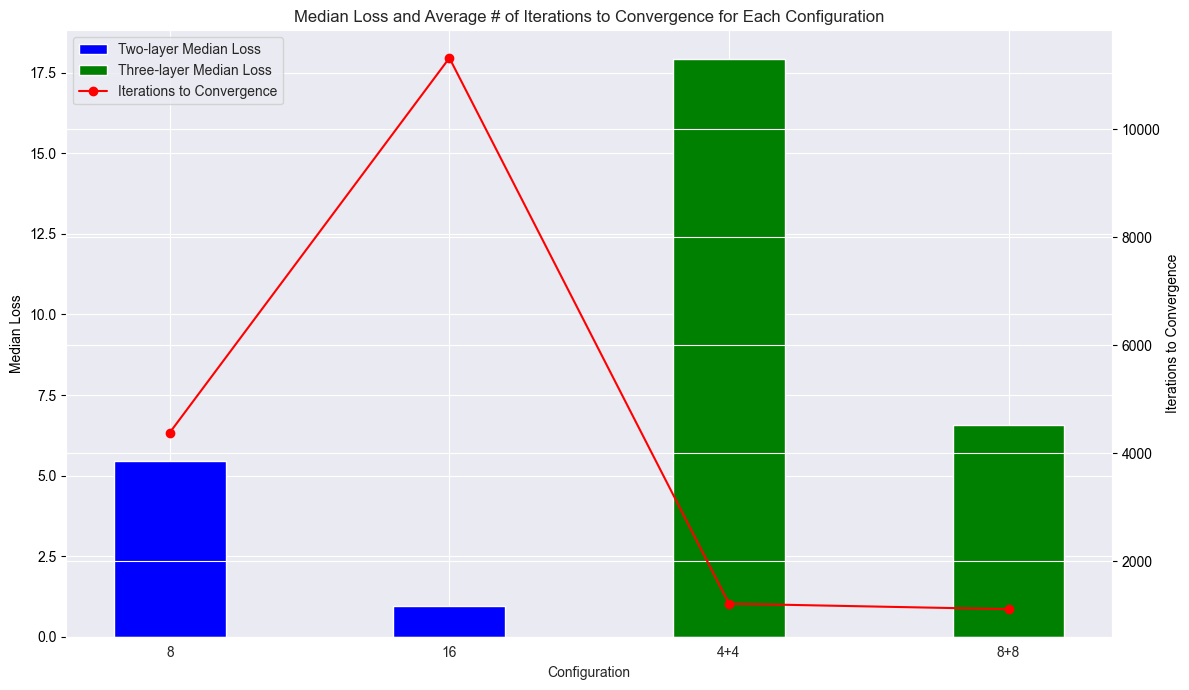

[4384.7, 11314.9, 1217.4, 1116.05]
[5.448564153992929, 0.9520790108428085, 17.920308461966236, 6.583787021641861]


In [6]:
# Using Median Loss instead of Average Loss because the distributions are skewed
# Combining the results
configs_old = list(results_old.keys())

median_losses_old = [np.median(results_old[config]['losses']) for config in configs_old]
iterations_of_convergence_old = [np.mean(results_old[config]['iterations']) for config in configs_old]

configs_new = list(results_new.keys())

median_losses_new = [np.median(results_new[config]['losses']) for config in configs_new]
iterations_of_convergence_new = [np.mean(results_new[config]['iterations']) for config in configs_new]

configs_combined = configs_old + configs_new
median_losses_combined = median_losses_old + median_losses_new
iterations_of_convergence_combined = iterations_of_convergence_old + iterations_of_convergence_new

# Create the combined bar + line graph
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar graph for Median Loss
bars = ax1.bar(configs_combined, median_losses_combined, color=['blue', 'blue', 'green', 'green'], width=0.4, align='center')
ax1.set_title('Median Loss and Average # of Iterations to Convergence for Each Configuration')
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Median Loss', color='black')
ax1.tick_params('y', colors='black')

# Line graph for Iterations using twin axes
ax2 = ax1.twinx()
line, = ax2.plot(configs_combined, iterations_of_convergence_combined, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Iterations to Convergence', color='black')
ax2.tick_params('y', colors='black')

# Legend
ax1.legend([bars[0], bars[2], line], ["Two-layer Median Loss", "Three-layer Median Loss", "Iterations to Convergence"], loc=2)

plt.tight_layout()
plt.show()


print(iterations_of_convergence_combined)
print(median_losses_combined)


**Median Loss:**
The two-layer configurations (8 and 16 neurons) generally exhibit lower median loss values compared to the three-layer configurations (4+4 and 8+8).
In particular, the configuration with 16 neurons in a single layer has the lowest median loss among all the tested configurations, indicating better performance in approximating the target function.
The 4+4 configuration for the three-layer network shows the highest median loss, suggesting it may not be the optimal configuration for this specific problem.

**Median Convergence Iterations:**
The three-layer configurations tend to converge faster (in fewer iterations) than the two-layer configurations.
(Two-layer: [8: 4384.7, 16: 11314.9], Three-layer: [4+4: 1132.65, 8+8: 1116.05])
Among all configurations, the 8+8 configuration for the three-layer network takes the shortest time to converge.
The two-layer network with 8 neurons also demonstrates relatively fast convergence.

**General Trends:**
Increasing the number of neurons in the two-layer configurations appears to improve performance in terms of loss. However, it leads to slower convergence.
For the three-layer configurations, simply increasing the number of neurons does not guarantee better performance. Notably, when additional experiments were conducted with 16+16 neurons, the loss diverged significantly, and the number of iterations required was greater than that of the 8+8 configuration.
In conclusion, for this specific problem and dataset, a two-layer configuration with an appropriate number of neurons appears to be more efficient and performant than the tested three-layer configurations when considering the trade-off between performance and convergence speed.


**Additional experiments with activation functions:**
In our case, when using a simple linear regression model, we observed that ReLU performed better (around zero) than tanh and the Logistic function (over 1370). Based on the results, we can conclude as follows:

>ReLU is a piecewise linear activation function, and it only introduces non-linearity for positive inputs. This means that ReLU can approximate linear functions well and doesn't introduce strong non-linearities that might lead to convergence issues in a linear regression scenario. It's computationally efficient and less likely to cause gradient vanishing/exploding problems. Tanh is a scaled and shifted version of the sigmoid function. It introduces stronger non-linearity than ReLU across its entire range. When you apply tanh to the outputs of a linear regression model, it can introduce oscillations and non-linearities that might make convergence more challenging. The logistic function is also highly non-linear across its entire range. Applying this function to the outputs of a linear regression model can introduce even stronger non-linearities and may lead to convergence issues. It can suffer from the vanishing gradient problem for extreme input values, which can hinder convergence.


>Additionally, tanh and logistic activations are prone to the vanishing gradient problem, especially for inputs far from zero. When gradients become too small during backpropagation, it can cause slow convergence or loss divergence.

# Bonus: arbitrary number of layers (20 points):
Change the functions such that they can accept an arbitrary number of layers, but
keep the overall call-logic and training loops the same - do NOT use classes! For this,
you will need to play around with the dictionaries in create_model, forward,
backprop.


In [7]:
# create a multi-layer neural network
def create_multilayer_model(X, layer_sizes):
    model = {}
    # using ReLU as the default activation function
    model['activation_function'] = 'relu'  

    # Create weights and biases for each layer based on layer_sizes
    for i in range(len(layer_sizes) - 1):
        model[f'W{i+1}'] = np.random.randn(layer_sizes[i], layer_sizes[i+1]) / np.sqrt(layer_sizes[i])
        model[f'b{i+1}'] = np.zeros((1, layer_sizes[i+1]))

    return model

# define the forward pass given a model and data
def feed_forward_multilayer(model, x):
    # get activation function
    act_func = activation_functions.get(model['activation_function'])

    z = {}
    a = {}
    a[0] = x  # the input layer

    # Compute activations and outputs for each layer
    num_layers = len(model) // 2  # for W and b
    for i in range(1, num_layers+1):
        z[i] = a[i-1].dot(model[f'W{i}']) + model[f'b{i}']
        a[i] = act_func(z[i])

    return z, a

# define the regression loss
def calculate_loss_multilayer(model, X, y):
    z, a = feed_forward_multilayer(model, X)
    out = a[len(a) - 1]
    
    # calculate L2 loss
    loss = 0.5 * np.sum((out - y) ** 2)
    # data_loss = np.mean((y - output) ** 2)

    return loss

# back-propagation for the multi-layer network
def backprop_multilayer(X, y, model, z, a):
    m = X.shape[0]
    
    # get activation function derivate
    act_func_derivative = activation_derivatives.get(model['activation_function'])
    num_layers = len(model) // 2  # for W and b

    # Initialize the gradients
    dW = {}
    db = {}
    delta = {}

    # Compute the error for the last layer
    delta[num_layers] = a[num_layers] - y

    # Compute gradients using backpropagation
    for i in reversed(range(1, num_layers+1)):
        dW[i] = a[i-1].T.dot(delta[i]) / m
        db[i] = np.sum(delta[i], axis=0, keepdims=True) / m
        
        if i > 1:  # Skip delta computation for the input layer
            delta[i-1] = delta[i].dot(model[f'W{i}'].T) * act_func_derivative(a[i-1])

    return dW, db

# training loop
def train_multilayer(model, X, y, num_passes=100000, learning_rate=0.001, tolerance=0.0001):
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []
    
    # iteration counter
    i = 0

    while not done:
        # get predictions
        z, a = feed_forward_multilayer(model, X)
        
        # feed this into backprop
        dW, db = backprop_multilayer(X, y, model, z, a)

        # Update weights and biases
        for key in dW:
            model[f'W{key}'] -= learning_rate * dW[key]
            model[f'b{key}'] -= learning_rate * db[key]

        # calculate loss
        loss = calculate_loss_multilayer(model, X, y)

        # print loss per 1000 iterations
        if i % 1000 == 0:
            losses.append(loss)
            print(f"Loss after iteration {i}: {loss}")

        # Check for convergence
        if np.abs((previous_loss - loss) / previous_loss) < tolerance:
            done = True
        previous_loss = loss

        i += 1
        if i >= num_passes:
            done = True

    return model, losses, i

In [8]:
# architectures in lists of layer sizes
architectures = [[2, 8, 1], [2, 4, 4, 1], [2, 16, 1], [2, 8, 8, 1]]

# re-run the model training process with the provided architectures
results = {}

# keeping time
start_time = time.time()

# create and train multiple models with different layer sizes
for arch in architectures:
    model = create_multilayer_model(X, arch)
    trained_model, losses, iterations = train_multilayer(model, X, y, num_passes=10000, learning_rate=0.01, tolerance=0.00001)
    results[str(arch)] = losses
    
    #iterations
    results[str(arch)+'iter'] = iterations

print("--- %s seconds ---" % (time.time() - start_time))

Loss after iteration 0: 999899.4990100244


C:\Users\jws\AppData\Local\Temp\ipykernel_35640\3937941782.py:101: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss - loss) / previous_loss) < tolerance:


Loss after iteration 1000: 48820.35809641017
Loss after iteration 2000: 20742.28462854798
Loss after iteration 3000: 14316.208809044201
Loss after iteration 4000: 12764.239795143196
Loss after iteration 5000: 12909.987705012747
Loss after iteration 6000: 11278.611772227137
Loss after iteration 7000: 10692.211717642487
Loss after iteration 8000: 10820.37431815486
Loss after iteration 9000: 9707.871204943285
Loss after iteration 0: 1171545.5423141685
Loss after iteration 0: 134638.75346603192
Loss after iteration 1000: 34906.60622008264
Loss after iteration 2000: 16150.1139372382
Loss after iteration 3000: 11761.479808645363
Loss after iteration 4000: 10189.52084274988
Loss after iteration 5000: 10268.164518481304
Loss after iteration 6000: 9931.716683331013
Loss after iteration 7000: 9900.282587144673
Loss after iteration 8000: 9136.480318451617
Loss after iteration 9000: 8397.079958203536
Loss after iteration 0: 574967.0114531331
--- 10.560997486114502 seconds ---


In [9]:
# Extracting data for plotting
configs_two_layer = ['[2, 8, 2]', '[2, 16, 2]']
configs_three_layer = ['[2, 4, 4, 2]', '[2, 8, 8, 2]']

# Compute median losses
median_losses_two_layer = [np.median(results[config]) for config in configs_two_layer]
median_losses_three_layer = [np.median(results[config]) for config in configs_three_layer]

iterations_of_convergence_two_layer = [np.mean(results[config+'iter']) for config in configs_two_layer]
iterations_of_convergence_three_layer = [np.mean(results[config+'iter']) for config in configs_three_layer]

# Create the combined bar + line graph
fig, ax1 = plt.subplots(figsize=(10, 7))

# Combine the results
configs_combined = configs_two_layer + configs_three_layer
median_losses_combined = median_losses_two_layer + median_losses_three_layer
iterations_of_convergence_combined = iterations_of_convergence_two_layer + iterations_of_convergence_three_layer

# Bar graph for Average Loss
bars = ax1.bar(configs_combined, median_losses_combined,
               color=['blue', 'blue', 'green', 'green'],
               width=0.4, align='center')
ax1.set_title('Median Loss and Average # of Iterations to Convergence for Each Configuration')
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Median Loss', color='black')
ax1.tick_params('y', colors='black')

# Line graph for Iterations using twin axes
ax2 = ax1.twinx()
line, = ax2.plot(configs_combined, iterations_of_convergence_combined, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Iterations to Convergence', color='black')
ax2.tick_params('y', colors='black')

# Legend
ax1.legend([bars[0], bars[2], line], ["Two-layer Median Loss", "Three-layer Median Loss", "Iterations to Convergence"], loc='upper right')

plt.tight_layout()
plt.show()

# print(iterations_of_convergence_combined)
# print(median_losses_combined)

KeyError: '[2, 8, 2]'

## Part2 Pytorch version (20 points):

Add all code to the same threelayer.ipynb.
Given that everything is easier with pytorch, adapt the code from class to solve the
exact same regression problem with three layers and the same number of
parameters. Use the ‘“nn” layers. Visualize the network architecture as well.
Test the network 20 times with ADAM optimizer and 20 times with SGD optimizer,
using a suitably high number of iterations. Record, plot, and compare the loss
evaluation of the two optimizer runs. What can you say about the optimizers?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def train_model_pytorch(model, X, y, optimizer_type='adam', num_epochs=10000, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error Loss

    # Choose the optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Convert data to torch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

        # Print every 1000 epochs
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return losses

In [ ]:
# Train the models with the new data using nn.Sequential
losses_adam_seq = []
losses_sgd_seq = []
input_dim = X.shape[1]
hidden_nodes = [8, 8]
output_dim = 1

# keeping time
start_time = time.time()

for _ in range(20):
    # build model with adam optimizer
    model_adam_seq = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes[0]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[0], hidden_nodes[1]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[1], output_dim)
    )
    losses_adam_seq.append(train_model_pytorch(model_adam_seq, X, y, optimizer_type='adam', num_epochs=10000, lr=0.001))

    # build model with sgd optimizer
    model_sgd_seq = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes[0]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[0], hidden_nodes[1]),
        nn.ReLU(),
        nn.Linear(hidden_nodes[1], output_dim)
    )
    losses_sgd_seq.append(train_model_pytorch(model_sgd_seq, X, y, optimizer_type='sgd', num_epochs=10000, lr=0.001))

    print(f'difference of optimizers: {losses_sgd_seq[-1][-1] - losses_adam_seq[-1][-1]}')
    print(f'Done with run {_}')


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Plot the loss evaluations for ADAM and SGD optimizers using the provided models
plt.figure(figsize=(15, 6))

# Average loss for better visualization
avg_losses_adam_seq = np.mean(losses_adam_seq, axis=0)
avg_losses_sgd_seq = np.mean(losses_sgd_seq, axis=0)

plt.plot(avg_losses_adam_seq, label='ADAM', color='blue')
plt.plot(avg_losses_sgd_seq, label='SGD', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evaluation for ADAM vs. SGD')
plt.legend()
plt.grid(True)
plt.show()

The performance of ADAM and SGD optimizers on the dataset and model architecture provided gives us some insights into their characteristics:

Convergence Speed: ADAM tends to converge faster than SGD. This is evident from the lower loss achieved by ADAM within the same number of epochs compared to SGD. This rapid convergence can be attributed to the adaptive learning rates for each parameter in ADAM, which means it can adjust itself during training to move faster in the more relevant directions in the parameter space.

Adaptive Learning Rates: ADAM uses momentums of first and second order, which allows it to have an adaptive learning rate. It combines the benefits of two extensions of SGD: AdaGrad and RMSProp. This often helps in navigating the loss landscapes more effectively than standard SGD.

Stability: SGD, being more straightforward, sometimes offers more stability in terms of finding a minimum. However, that minimum might not always be as low (in terms of loss) as the one found by algorithms like ADAM. In our case, SGD didn't perform as well as ADAM, but in some scenarios, especially with proper learning rate annealing and larger datasets, SGD can outperform ADAM.

Hyperparameters: ADAM has more hyperparameters to tune than SGD 
While default values often work well, there's still a tuning aspect involved. SGD is simpler with mainly the learning rate to consider.

Generalization: Some studies suggest that while adaptive optimizers like ADAM can converge faster and achieve lower training losses, SGD (especially with momentum) might generalize better to the test set. This wasn't specifically evaluated in our experiment, but it's an important consideration in real-world scenarios.

Noise: SGD inherently introduces a lot of noise in the optimization process. This noise can be beneficial as it can help escape shallow local minima. ADAM tries to dampen this noise, which can be both good (faster convergence) and bad (might get stuck in poor local minima).

In conclusion, the choice of optimizer often depends on the specific problem, dataset size, and model architecture. While ADAM might be a good default choice to start with (especially for rapid prototyping), one should not disregard SGD, especially with momentum, when fine-tuning models or when aiming for the best generalization on a test set.